In [1]:
pip install uszipcode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head() #original dataframe

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#To get edited dataframe, just run this cell first
def make_month(string):
    if string[:2] == '1/':
        return 'Jan'
    if string[:2] == '2/':
        return 'Feb'
    if string[:2] == '3/':
        return 'Mar'
    if string[:2] == '4/':
        return 'Apr'
    if string[:2] == '5/':
        return 'May'
    if string[:2] == '6/':
        return 'Jun'
    if string[:2] == '7/':
        return 'Jul'
    if string[:2] == '8/':
        return 'Aug'
    if string[:2] == '9/':
        return 'Sep'
    if string[:2] == '10':
        return 'Oct'
    if string[:2] == '11':
        return 'Nov'
    if string[:2] == '12':
        return 'Dec'

In [5]:
#Then run this cell
df_alt = df.drop(['id', 'date', 'yr_built', 'yr_renovated'], axis = 1)
month_list = []
sqft_basement_list = []
yr_renovated = []
for date in df['date'].values:
    month_list.append(make_month(date))
for num in df['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
for data in df['yr_renovated'].values:
    if data == 0:
        yr_renovated.append(0)
    elif data == np.nan:
        yr_renovated.append(np.nan)
    else:
        yr_renovated.append(1)
        
df_alt['month'] = month_list
df_alt['sqft_basement'] = sqft_basement_list
df_alt['renovated'] = yr_renovated
# df_alt['zipcode'] = df_alt['zipcode'].apply(str) - DT, can delete?
df_alt['age_of_house'] = 2021 - df['yr_built']
# df_alt['total_sq_ft'] = df['sqft_above'] + df_alt['sqft_basement'] - DT, can delete?
df_alt.head() #df_alt is the new dataframe


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,Oct,0,66
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,Dec,1,70
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,Feb,1,88
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,Dec,0,56
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,Feb,0,34


In [6]:
#converting zipcode to city
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

df_alt['City'] = df_alt['zipcode'].apply(zip_lookup)

In [7]:
#previewing the geography of our data
df_alt['City'].value_counts()

Seattle          8973
Renton           1597
Bellevue         1407
Kent             1201
Redmond           977
Kirkland          977
Auburn            911
Sammamish         800
Federal Way       779
Issaquah          733
Maple Valley      589
Woodinville       471
Snoqualmie        308
Kenmore           283
Mercer Island     282
Enumclaw          233
North Bend        220
Bothell           195
Duvall            190
Carnation         124
Vashon            117
Black Diamond     100
Fall City          80
Medina             50
Name: City, dtype: int64

In [8]:
# Here is my logic for all the edits I made but of course, feel free to make your own edits too

## dropped'id' because it's useless lol
## dropped 'date' because its too specific and replaced with a column that shows month categorically
## dropped'yr_built' because it doesn't tell us much BUT I also replaced with this column with 
# age_of_house which shows how old the home is in years
## dropped'yr_renovated' and made categorical (renovated) as to whether it has been renovated or not
## dropped 'lat', feels useless
## dropped 'long', feels useless
## made zipcode into a string to make categorical
## made sqft_basement into floats (it was in string format)
## created a total_sq_ft column combining basement sq fit with the rest of the house

#DT - 
#can probably drop 'view'?
#sqft_living and total_sq_ft are the same

In [9]:
display(df_alt['sqft_living'].describe())

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [10]:
categorical = ['waterfront', 'grade', 'condition', 'month', 'renovated']
continuous = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_living15', 'sqft_lot15', 'age_of_house']

In [11]:
#stats-model method

#creating variables to predict target
df_preds_continuous = df_alt[continuous]
# df_preds_categorical = pd.get_dummies(df[categorical], prefix=categorical, drop_first = True)
# df_preds_total = pd.concat([df_preds_continuous, df_preds_categorical])
df_target = df_alt['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     3566.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:41:16   Log-Likelihood:            -2.9830e+05
No. Observations:               21597   AIC:                         5.966e+05
Df Residuals:                   21588   BIC:                         5.967e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.403e+05   1641.040    329.240      0.000    5.37e+05    5.44e+05
bedrooms      -6.118e+04   2062.707    -29.659      0.000   -6.52e+04   -5.71e+04
bathrooms      5.442e+04   2923.667     18.613      0.000    4.87e+04    6.02e+04
sqft_living     2.31e+05   3395.509     68.036      0.000    2.24e+05    2.38e+05
sqft_lot        571.7647   2365.825      0.242      0.809   -4065.428    5208.957
floors         2.996e+04   2012.276     14.887      0.000     2.6e+04    3.39e+04
sqft_living15  6.282e+04   2552.173     24.615      0.000    5.78e+04    6.78e+04
sqft_lot15    -1.923e+04   2382.243     -8.070      0.000   -2.39e+04   -1.46e+04
age_of_house   1.056e+05   2051.091     51.476      0.000    1.02e+05     1.1e+05
==============================================================================
Omnibus:                    15512.972   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           718508.971
Skew:                           2.947   Prob(JB):                         0.00
Kurtosis:                      30.636   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How correlated are our continuous variables?

In [12]:
df_alt[continuous].corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_living15,sqft_lot15,age_of_house
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,0.393406,0.030690,-0.155670
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,0.569884,0.088303,-0.507173
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,0.756402,0.184342,-0.318152
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,0.144763,0.718204,-0.052946
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,0.280102,-0.010722,-0.489193
sqft_living15,0.393406,0.569884,0.756402,0.144763,0.280102,1.000000,0.183515,-0.326377
sqft_lot15,0.030690,0.088303,0.184342,0.718204,-0.010722,0.183515,1.000000,-0.070777
age_of_house,-0.155670,-0.507173,-0.318152,-0.052946,-0.489193,-0.326377,-0.070777,1.000000


Let's isolate the variables with "high correlation"

In [13]:
#let's isolate the variables with "high correlation"
df_corr = df_alt[continuous].corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

df_corr.set_index(['pairs'], inplace = True)

df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df_corr.columns = ['cc']

df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc<1)]

,cc
pairs,
"(sqft_living, sqft_living15)",0.756402
"(bathrooms, sqft_living)",0.755758


Based on this, let's re-declare our categorical variables. Dropped sqft_living15 and bathrooms b/c of correlation with sqft_living. Dropped sqft_lot because high prob (.809), meaning there isn't a statistically significant correlation between price and sqft_lot (footage of the lot).

In [14]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'sqft_lot15', 'age_of_house']

#creating variables to predict target
df_preds_continuous = df_alt[continuous]
df_target = df_alt['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     5299.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:41:16   Log-Likelihood:            -2.9874e+05
No. Observations:               21597   AIC:                         5.975e+05
Df Residuals:                   21591   BIC:                         5.975e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.403e+05   1675.269    322.513      0.000    5.37e+05    5.44e+05
bedrooms     -5.782e+04   2064.864    -28.002      0.000   -6.19e+04   -5.38e+04
sqft_living   3.089e+05   2240.436    137.885      0.000    3.05e+05    3.13e+05
floors        3.739e+04   1988.951     18.796      0.000    3.35e+04    4.13e+04
sqft_lot15   -1.822e+04   1720.854    -10.587      0.000   -2.16e+04   -1.48e+04
age_of_house  8.646e+04   1955.009     44.226      0.000    8.26e+04    9.03e+04
==============================================================================
Omnibus:                    14242.664   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           512448.324
Skew:                           2.665   Prob(JB):                         0.00
Kurtosis:                      26.261   Cond. No.                         2.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#Assumptions for linear regression

#1. The relationship between the target and predictor is linear
#2. The errors are independent
#3. The errors are normally distributed
#4. The errors are homoskedastic (errors have the same variance)

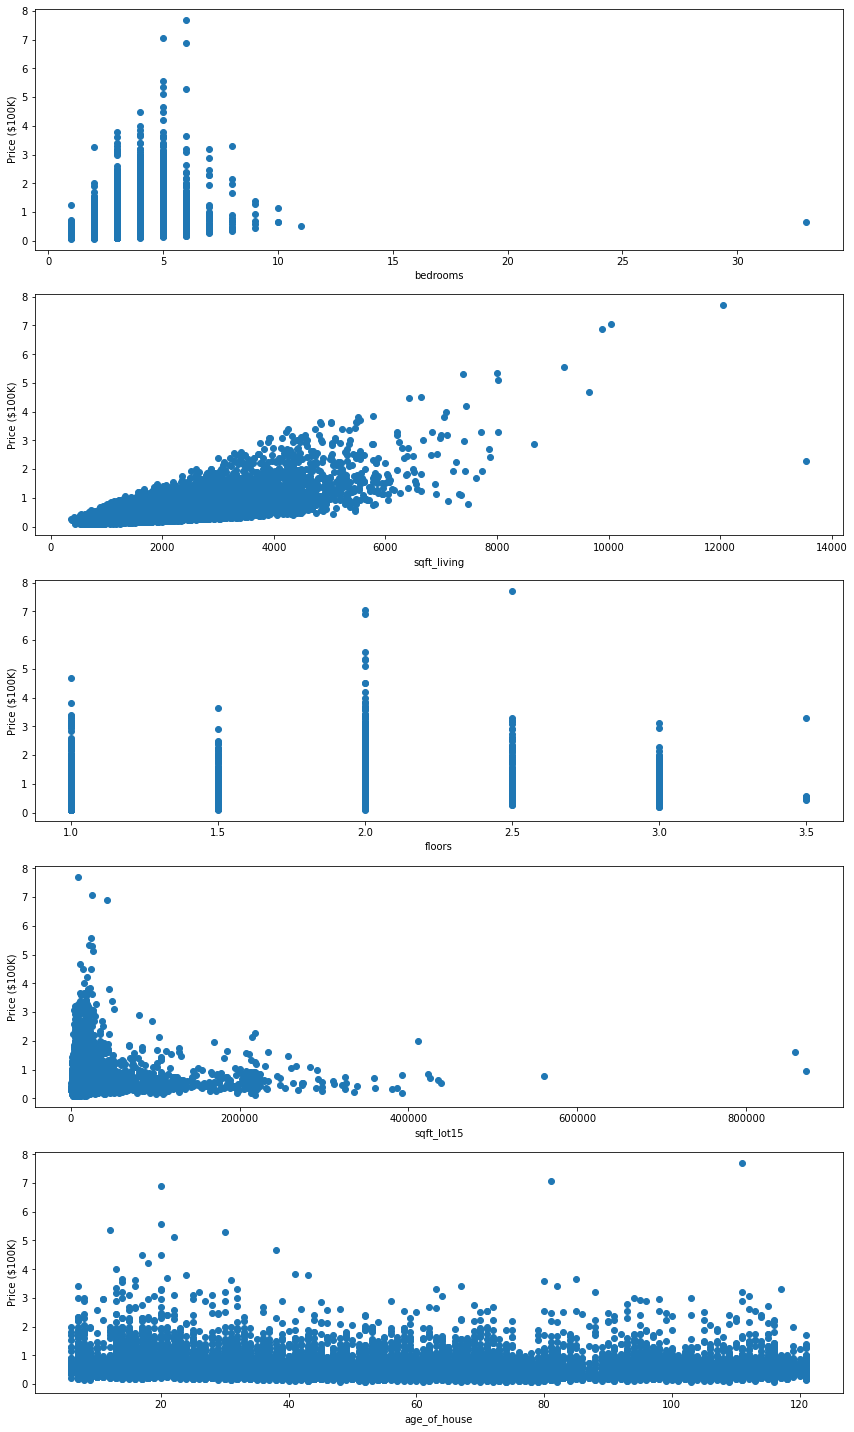

In [16]:
#1. The relationship between the target and predictor is linear - FALSE

fig, ax = plt.subplots(len(continuous), figsize=(12, 20)) 

for x in range(0,len(continuous)):
    ax[x].scatter(y=df_alt['price']/1000000, x=df_alt[continuous[x]])
    ax[x].set_xlabel(continuous[x])
    ax[x].set_ylabel('Price ($100K)')
    
plt.tight_layout()

In [17]:
#2. The errors are independent - TRUE

#The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. 
#The Durbin-Watson statistic will always have a value between 0 and 4. 
#A value of 2.0 means that there is no autocorrelation detected in the sample. 
#Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation.

#source: https://www.investopedia.com/terms/d/durbin-watson-statistic.asp#:~:text=The%20Durbin%2DWatson%20statistic%20will,to%204%20indicate%20negative%20autocorrelation.

# The DW statistic is 1.986, indicating there is minimal autocorrelation. 

<ipython-input-18-22bd4f592d58>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


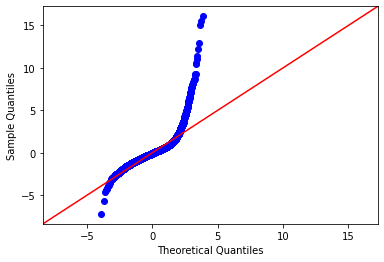

In [18]:
#3. The errors are normally distributed - FALSE

#JB score is much larger than 6, indicating errors are not normally distributed

#Confirm this with QQ plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

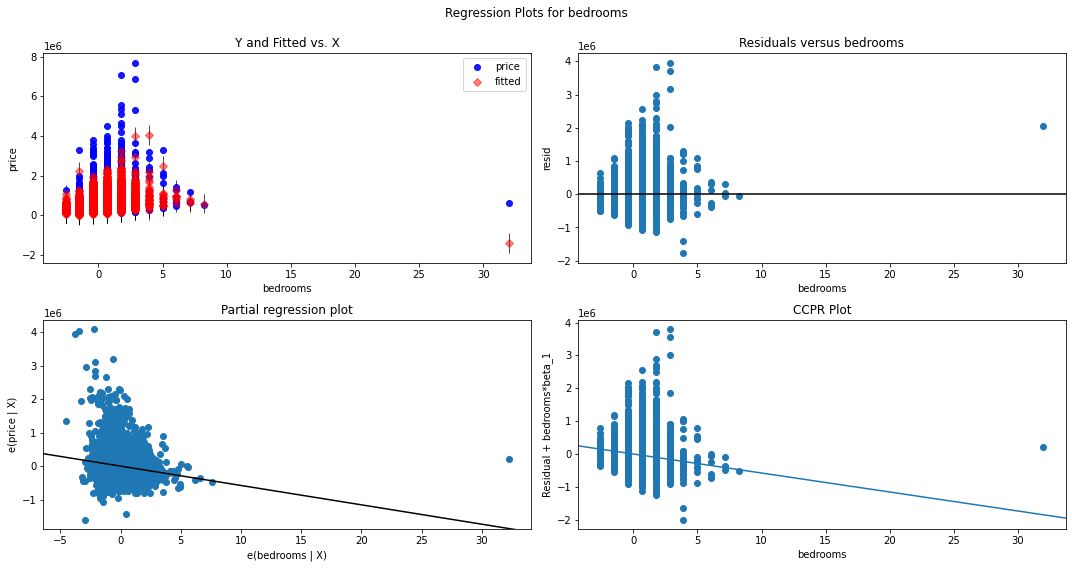

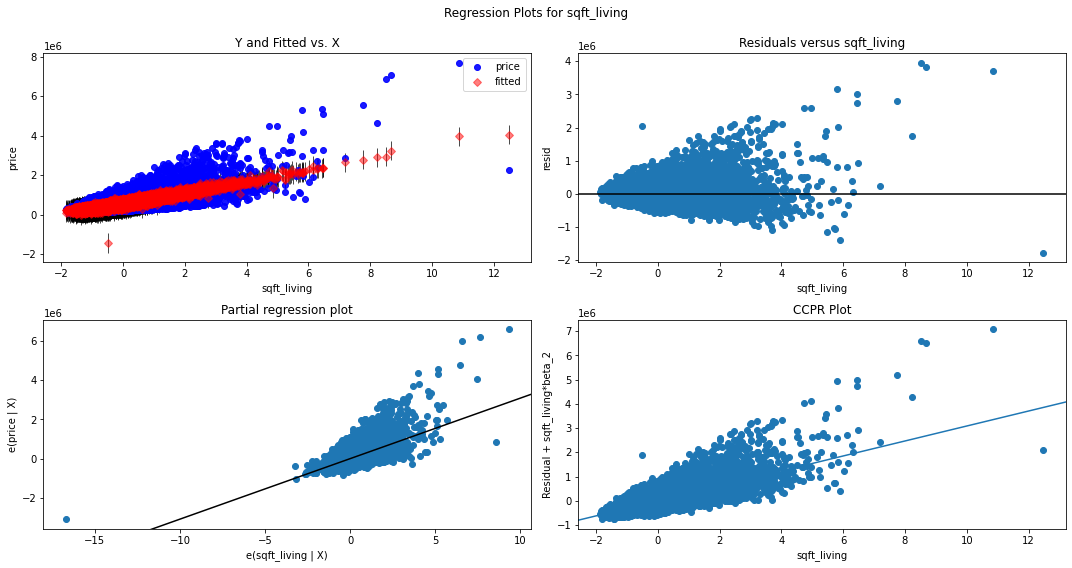

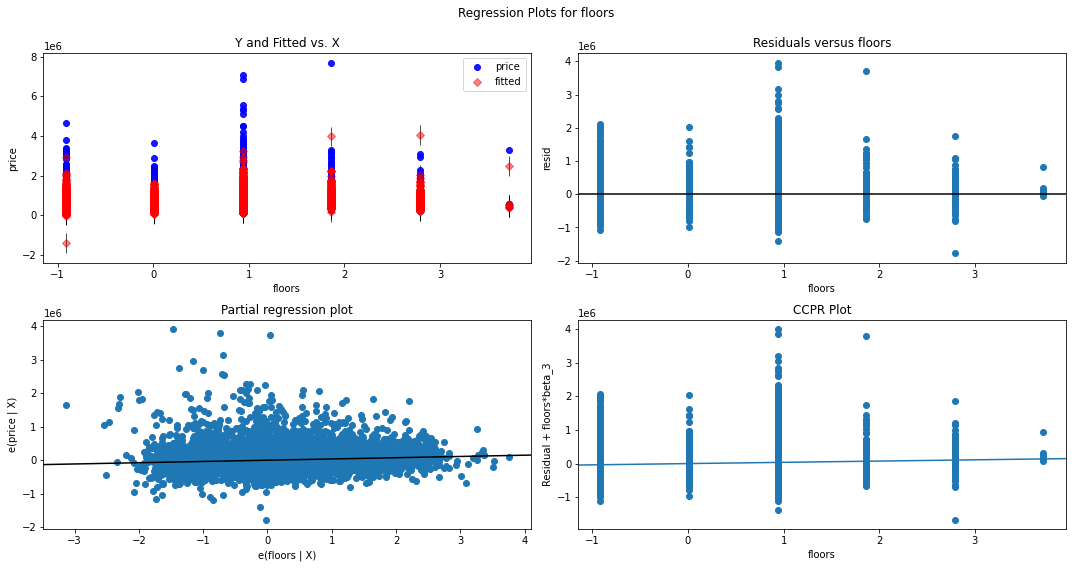

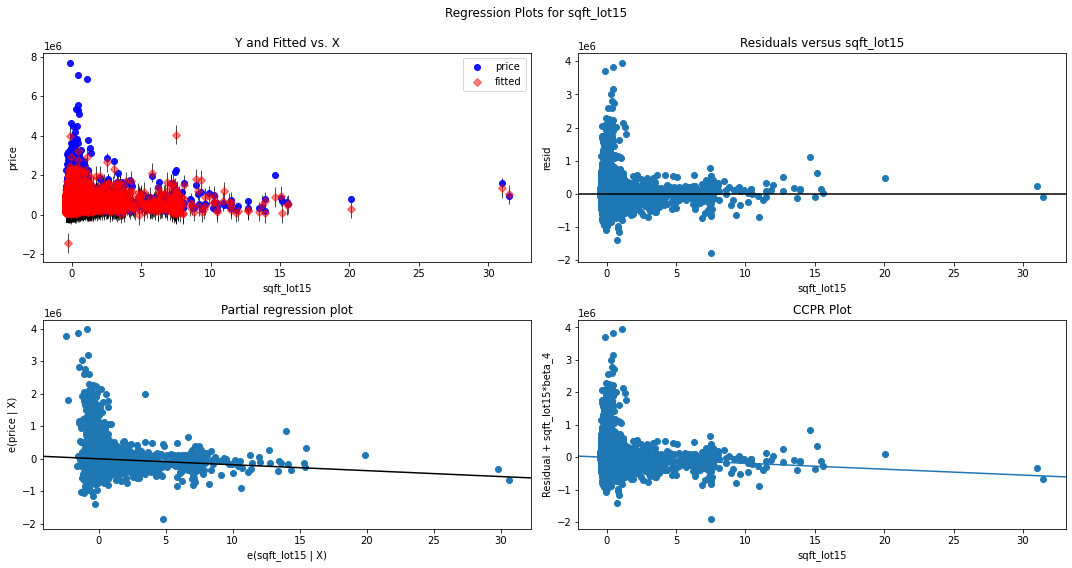

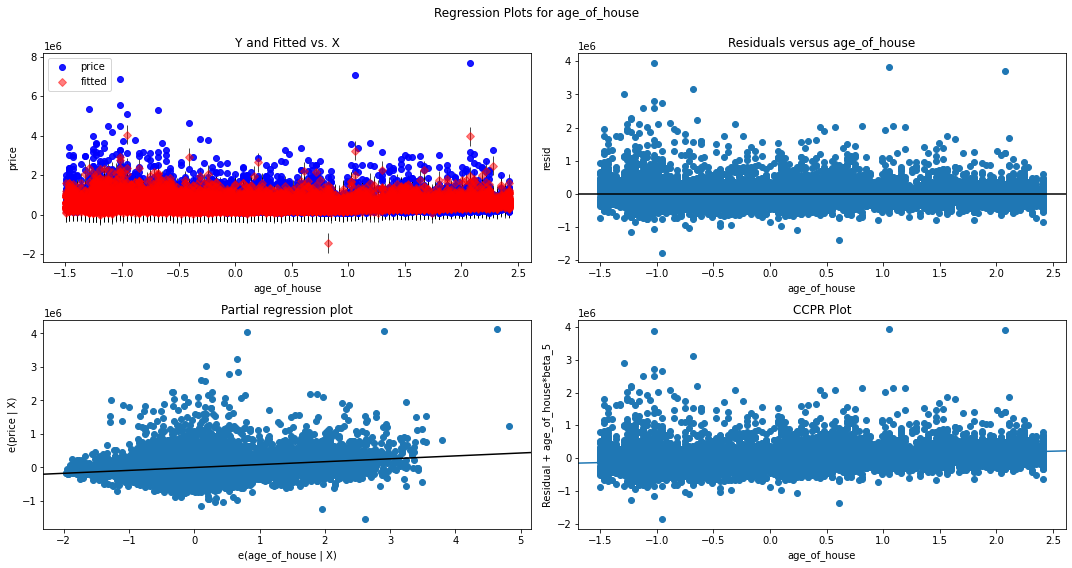

In [19]:
for x in range(0,len(continuous)):
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, continuous[x], fig=fig)
    plt.show()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

(array([1.9662e+04, 1.9110e+03, 2.2000e+01, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <BarContainer object of 10 artists>)

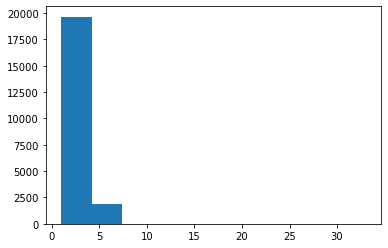

In [20]:
display(df_alt.bedrooms.value_counts(), df_alt.bedrooms.describe())

plt.hist(df_alt.bedrooms)

#Limit bedrooms to 2 - 5?

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

(array([8.3540e+03, 1.0165e+04, 2.5810e+03, 3.9500e+02, 7.2000e+01,
        2.3000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  370.,  1687.,  3004.,  4321.,  5638.,  6955.,  8272.,  9589.,
        10906., 12223., 13540.]),
 <BarContainer object of 10 artists>)

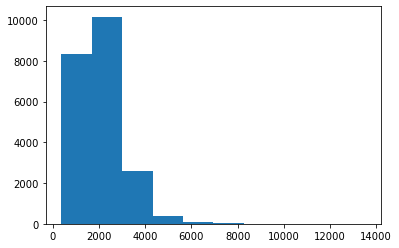

In [21]:
display(df_alt.sqft_living.describe())

plt.hist(df_alt.sqft_living)

#limit to less than 3,000 sq ft?

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

(array([2.1201e+04, 1.9600e+02, 1.6500e+02, 2.1000e+01, 1.0000e+01,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([6.510000e+02, 8.770590e+04, 1.747608e+05, 2.618157e+05,
        3.488706e+05, 4.359255e+05, 5.229804e+05, 6.100353e+05,
        6.970902e+05, 7.841451e+05, 8.712000e+05]),
 <BarContainer object of 10 artists>)

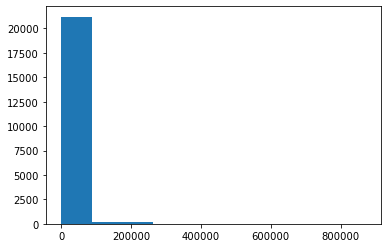

In [22]:
display(df_alt.sqft_lot15.describe())

plt.hist(df_alt.sqft_lot15)

#limit to less than 15,000 sq ft of the land lots of the nearest 15 neighbors?
#decision - drop this field

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

(array([1.0673e+04, 0.0000e+00, 1.9100e+03, 0.0000e+00, 8.2350e+03,
        0.0000e+00, 1.6100e+02, 0.0000e+00, 6.1100e+02, 7.0000e+00]),
 array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ]),
 <BarContainer object of 10 artists>)

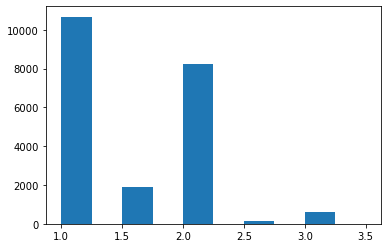

In [23]:
display(df_alt.floors.value_counts(), df_alt.floors.describe())

plt.hist(df_alt.floors)

#limit to houses with either 1 or 2 floors?
#is there a statistically significant difference in prices between houses with either 1 or 2 floors?

In [24]:
df_alt_no_outliers = df_alt[(df_alt.bedrooms <= 5) & (df_alt.bedrooms >=2) & (df_alt.sqft_living <= 3000) & 
                            ((df_alt.floors == 1) | (df_alt.floors ==2))]

df_alt_no_outliers_seattle = df_alt_no_outliers[df_alt_no_outliers['City'] == 'Seattle']
df_alt_no_outliers_seattle

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340,5650,Oct,0,66,Seattle
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400.0,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910.0,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,...,0.0,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle
8,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,...,730.0,98146,47.5123,-122.337,1780,8113,Apr,0,61,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,0.0,3,8,...,0.0,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,...,130.0,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,...,0.0,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,...,0.0,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle


In [25]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'sqft_lot15', 'age_of_house']

df_preds_continuous = df_alt_no_outliers[continuous]
df_target = df_alt_no_outliers['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     1704.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:41:32   Log-Likelihood:            -2.1236e+05
No. Observations:               15791   AIC:                         4.247e+05
Df Residuals:                   15785   BIC:                         4.248e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.477e+05   1334.221    335.574      0.000    4.45e+05     4.5e+05
bedrooms     -3.043e+04   1681.375    -18.099      0.000   -3.37e+04   -2.71e+04
sqft_living   1.382e+05   1824.136     75.746      0.000    1.35e+05    1.42e+05
floors        2.902e+04   1658.295     17.501      0.000    2.58e+04    3.23e+04
sqft_lot15   -3137.6104   1352.177     -2.320      0.020   -5788.031    -487.190
age_of_house  6.346e+04   1621.045     39.147      0.000    6.03e+04    6.66e+04
==============================================================================
Omnibus:                     4718.469   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23182.131
Skew:                           1.366   Prob(JB):                         0.00
Kurtosis:                       8.269   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

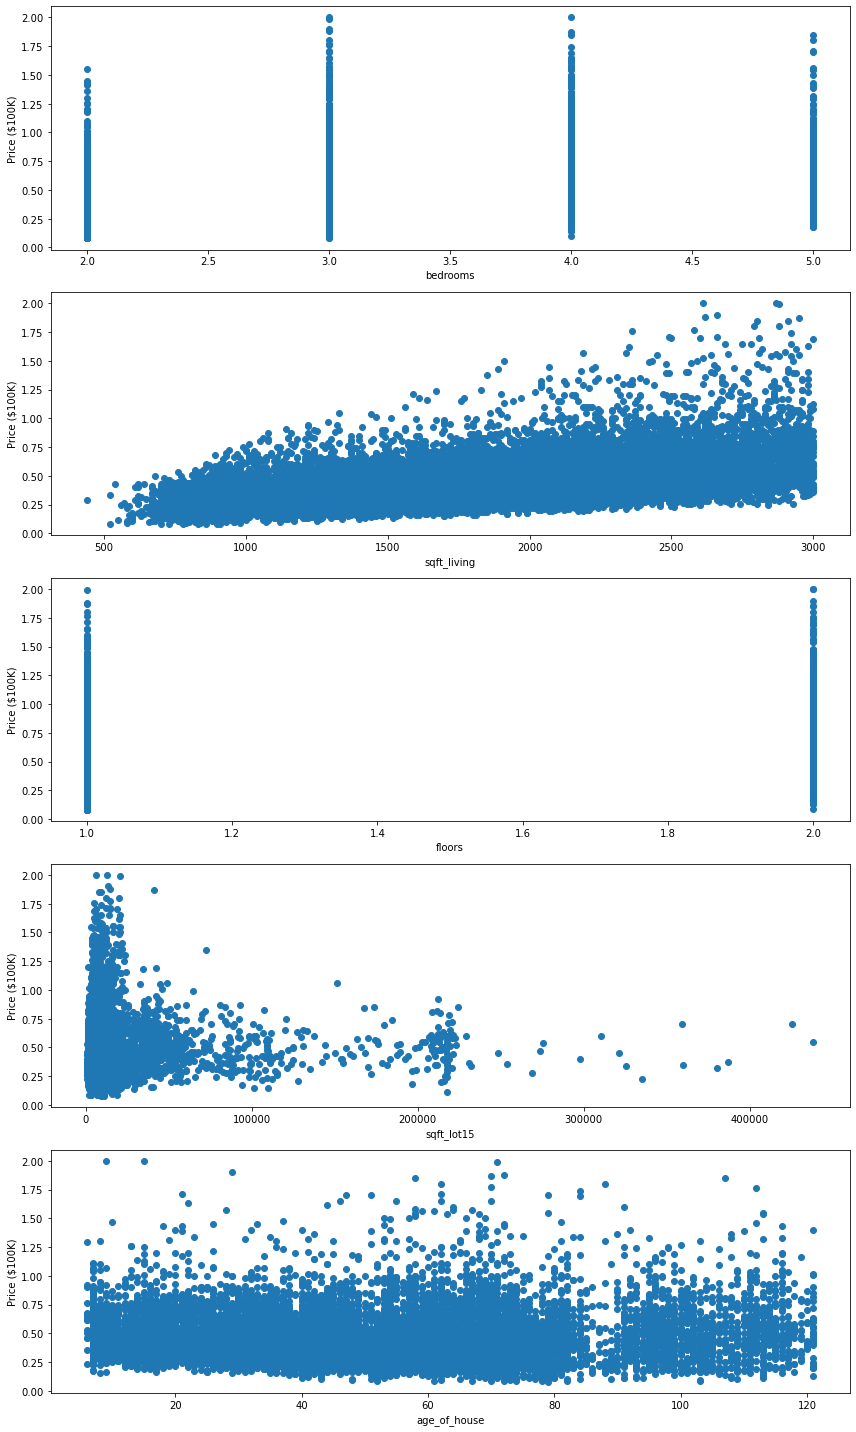

In [26]:
#1. The relationship between the target and predictor is linear - FALSE

fig, ax = plt.subplots(len(continuous), figsize=(12, 20)) 

for x in range(0,len(continuous)):
    ax[x].scatter(y=df_alt_no_outliers['price']/1000000, x=df_alt_no_outliers[continuous[x]])
    ax[x].set_xlabel(continuous[x])
    ax[x].set_ylabel('Price ($100K)')
    
plt.tight_layout()

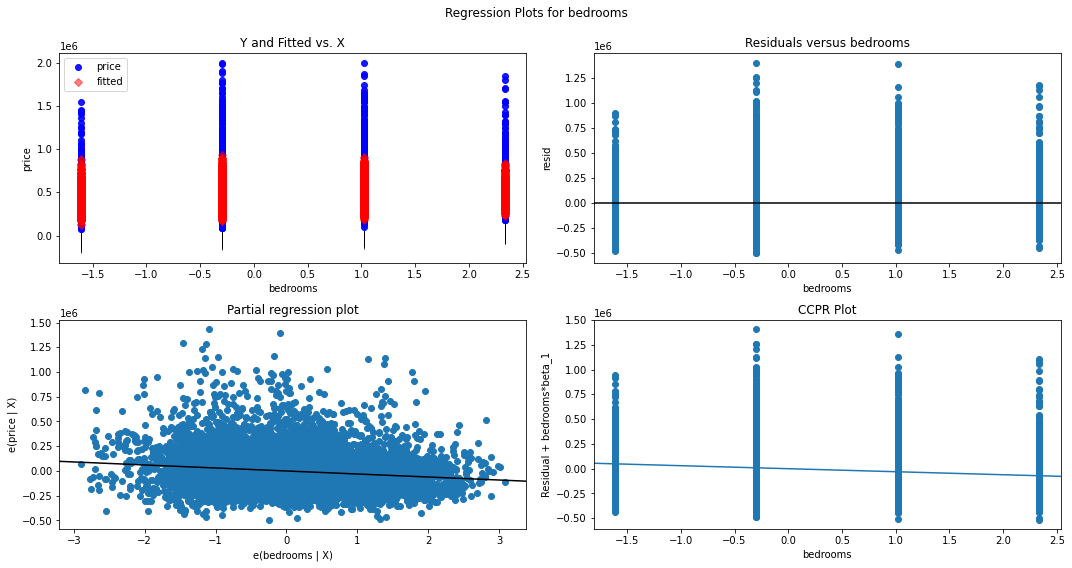

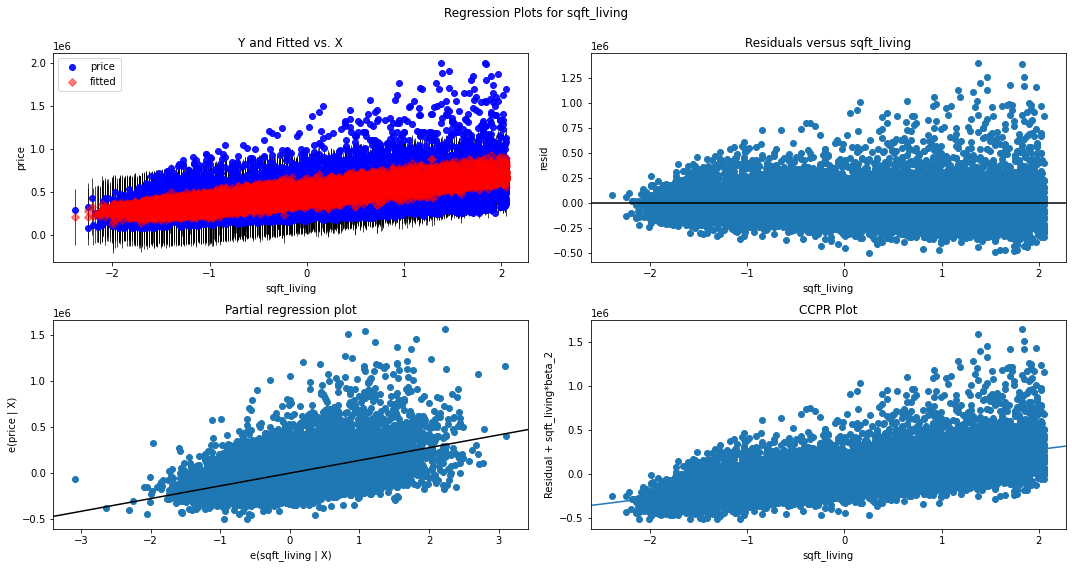

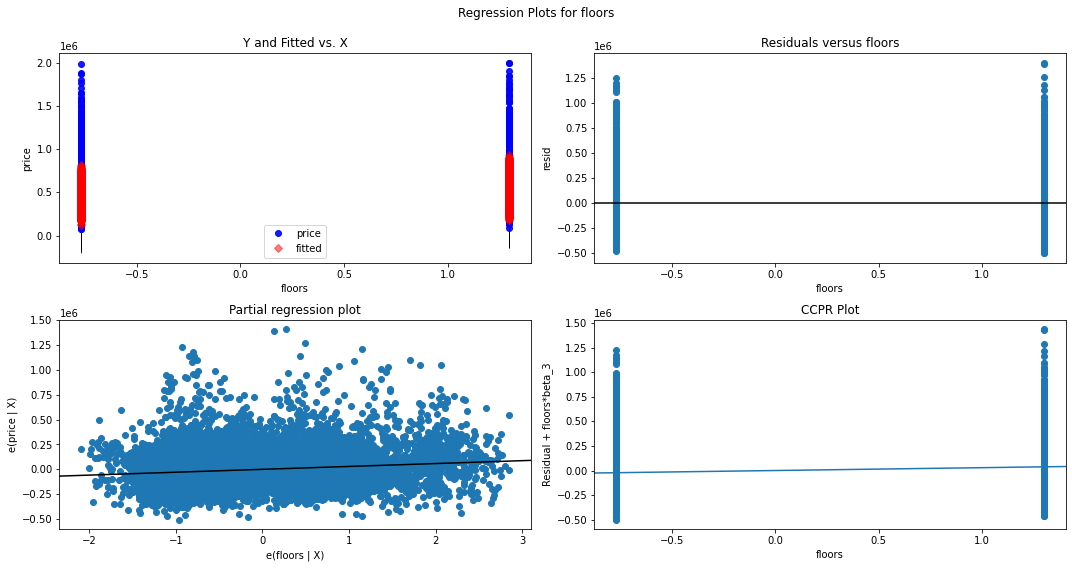

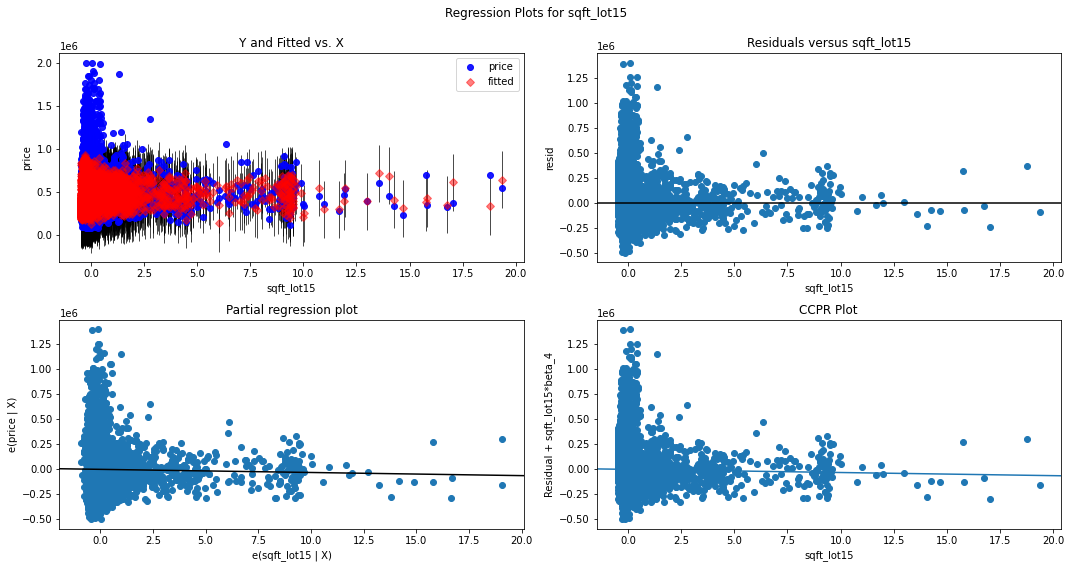

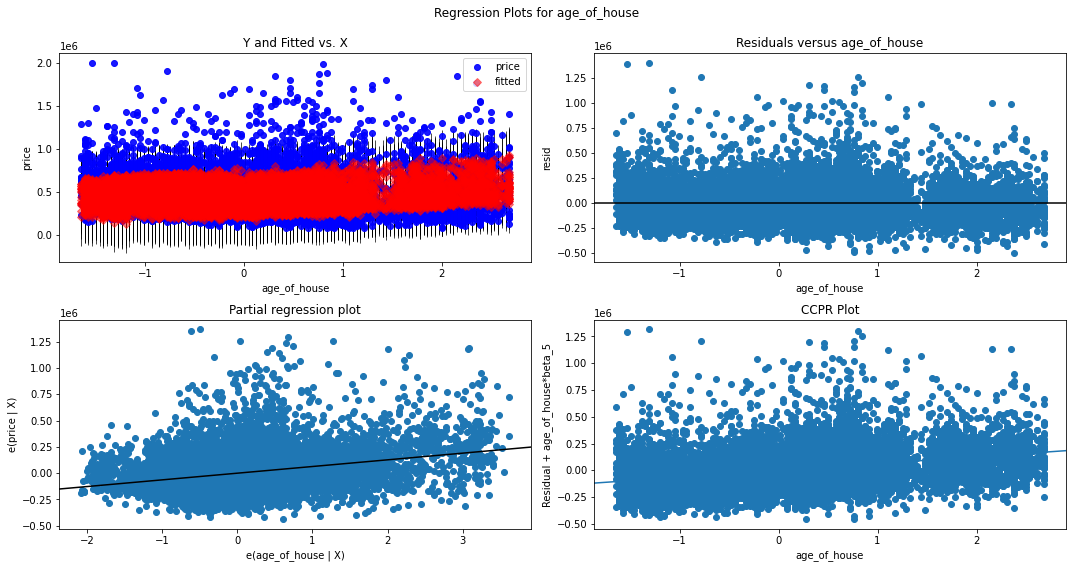

In [27]:
for x in range(0,len(continuous)):
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, continuous[x], fig=fig)
    plt.show()

In [28]:
continuous = ['sqft_living']

df_preds_continuous = df_alt_no_outliers[continuous]
df_target = df_alt_no_outliers['price']

model = sm.OLS(df_target, df_preds_continuous).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                          1.024e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        10:41:43   Log-Likelihood:                     -2.1353e+05
No. Observations:               15791   AIC:                                  4.271e+05
Df Residuals:                   15790   BIC:                                  4.271e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   241.1072      0.754    319.940      0.000     239.630     242.584
==============================================================================
Omnibus:                     3965.706   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14835.920
Skew:                           1.220   Prob(JB):                         0.00
Kurtosis:                       7.073   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
df_alt_no_outliers_seattle['price_adjusted_M'] = df_alt_no_outliers_seattle['price'] / 1000000
df_alt_no_outliers_seattle

std = df_alt_no_outliers_seattle['price_adjusted_M'].std()
mean = df_alt_no_outliers_seattle['price_adjusted_M'].mean()

lower_bound = mean - std
upper_bound = mean + std

df_alt_no_outliers_seattle = df_alt_no_outliers_seattle[(df_alt_no_outliers_seattle['price_adjusted_M'] >= lower_bound) & 
        (df_alt_no_outliers_seattle['price_adjusted_M'] <= upper_bound)]
df_alt_no_outliers_seattle

<ipython-input-29-173a3cba8fb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alt_no_outliers_seattle['price_adjusted_M'] = df_alt_no_outliers_seattle['price'] / 1000000


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle,0.538000
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle,0.604000
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,...,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle,0.291850
11,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,4,7,...,98115,47.6900,-122.292,1330,6000,May,0,79,Seattle,0.468000
15,650000.0,4,3.00,2950,5000,2.0,0.0,3.0,3,9,...,98126,47.5714,-122.375,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,0.0,3,8,...,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle,0.572000
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,...,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle,0.475000
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,...,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle,0.400000
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,...,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle,0.402101


In [30]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'sqft_lot15', 'age_of_house']

for variable in continuous:
    df_preds_continuous = df_alt_no_outliers[variable]
    df_target = df_alt_no_outliers['price']

    model = sm.OLS(df_target, df_preds_continuous).fit()
    print(variable, 'r-squared value:', model.rsquared)
    


bedrooms r-squared value: 0.8159948827915657
sqft_living r-squared value: 0.8663582375347924
floors r-squared value: 0.7821824042504234
sqft_lot15 r-squared value: 0.18784789720186557
age_of_house r-squared value: 0.6479131449543545


## Categorical Variables

In [31]:
df_alt_no_outliers_seattle

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle,0.538000
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle,0.604000
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,...,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle,0.291850
11,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,4,7,...,98115,47.6900,-122.292,1330,6000,May,0,79,Seattle,0.468000
15,650000.0,4,3.00,2950,5000,2.0,0.0,3.0,3,9,...,98126,47.5714,-122.375,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,0.0,3,8,...,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle,0.572000
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,...,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle,0.475000
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,...,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle,0.400000
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,...,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle,0.402101


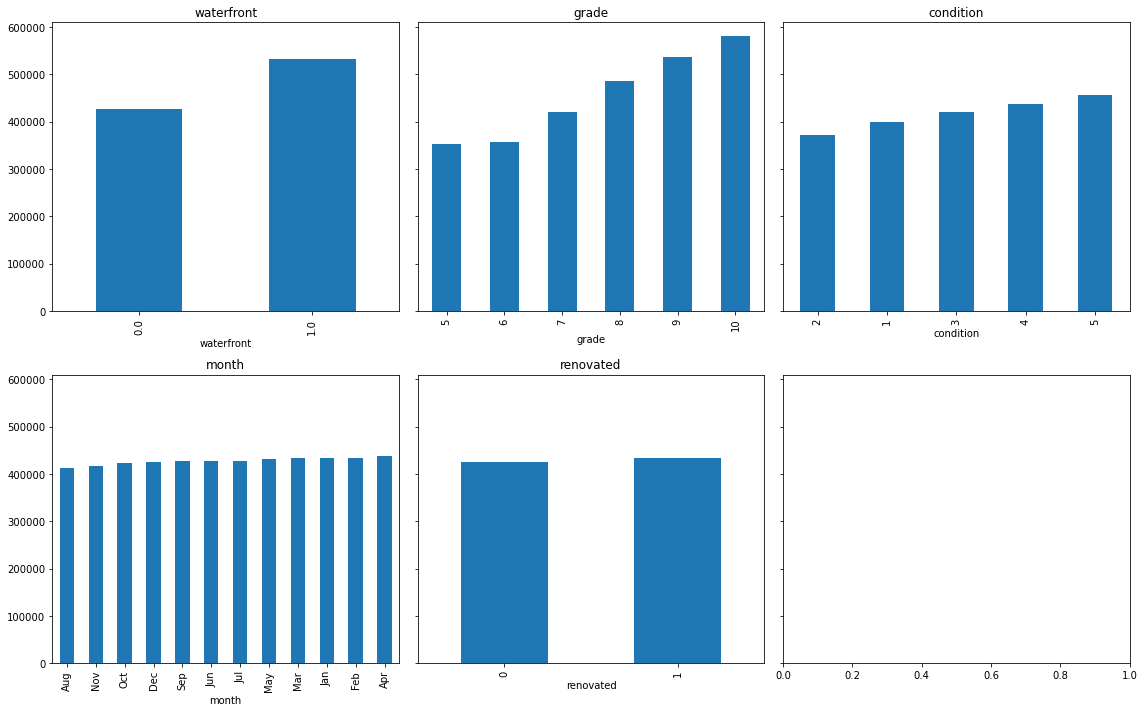

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10), sharey=True)

categorical = ['waterfront', 'grade', 'condition', 'month', 'renovated']

for col, ax in zip(categorical, axes.flatten()):
    (df_alt_no_outliers_seattle.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

BUILDING CONDITION
    	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.
____
BUILDING GRADE
    	Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [33]:
#is there a statistical difference in price between grade?
df_alt_no_outliers_seattle['grade'].value_counts()

7     2772
8     1009
6      721
9      113
5       30
10      10
Name: grade, dtype: int64

In [87]:
df_alt_no_outliers_seattle['condition'].value_counts()

3    3028
4    1166
5     421
2      34
1       6
Name: condition, dtype: int64

In [34]:
grade5_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 5]['price']
grade6_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 6]['price']
grade7_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 7]['price']
grade8_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 8]['price']
grade9_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 9]['price']
grade10_prices = df_alt_no_outliers_seattle[df_alt_no_outliers_seattle['grade'] == 10]['price']

lst = [grade5_prices, grade6_prices, grade7_prices, grade8_prices, grade9_prices, grade10_prices]

x = 5

for element in lst:
    print('Grade', x, 'average price:', element.mean().round(2))
    x += 1

Grade 5 average price: 352173.5
Grade 6 average price: 356016.47
Grade 7 average price: 420953.2
Grade 8 average price: 485829.25
Grade 9 average price: 537320.62
Grade 10 average price: 580795.0


In [35]:
#null = there is no difference in price between grades 5 and 6
#alternative = there is a difference in price between grades 5 and 6

stats.ttest_ind(grade5_prices, grade6_prices)

#fail to reject null

Ttest_indResult(statistic=-0.24984291259338196, pvalue=0.8027773388478812)

In [36]:
#null = there is no difference in price between grades 5 and 7
#alternative = there is a difference in price between grades 5 and 7

stats.ttest_ind(grade5_prices, grade7_prices)

#reject null. There is a statistically significant difference in price between grades 5 and 7.

Ttest_indResult(statistic=-3.5132014327931653, pvalue=0.00044975120864875)

In [37]:
#null = there is no difference in price between grades 6 and 7
#alternative = there is a difference in price between grades 6 and 7

stats.ttest_ind(grade6_prices, grade7_prices)

#reject null. There is a statistically significant difference in price between grades 6 and 7.

Ttest_indResult(statistic=-15.196961327111532, pvalue=1.4848337468581576e-50)

In [38]:
#null = there is no difference in price between grades 7 and 8
#alternative = there is a difference in price between grades 7 and 8

stats.ttest_ind(grade8_prices, grade7_prices)

#reject null. There is a statistically significant difference in price between grades 7 and 8.

Ttest_indResult(statistic=16.606608732506906, pvalue=7.850697528816686e-60)

In [39]:
#null = there is no difference in price between grades 8 and 9
#alternative = there is a difference in price between grades 8 and 9

stats.ttest_ind(grade8_prices, grade9_prices)

#reject null. There is a statistically significant difference in price between grades 8 and 9.

Ttest_indResult(statistic=-4.951966957076816, pvalue=8.475766920287858e-07)

In [40]:
#null = there is no difference in price between grades 9 and 10
#alternative = there is a difference in price between grades 9 and 10

stats.ttest_ind(grade10_prices, grade9_prices)

#fail to reject null

Ttest_indResult(statistic=1.2495054648967718, pvalue=0.2138918288627854)

In [41]:
#SUMMARY

#No difference in price between: 5 to 6 | 9 to 10
#Difference in price between 6 to 7 | 7 to 8 | 8 to 9

#T-test for confidence interval. 
#Note* if results were significant for Grade 10,  cannot rely on CI, since n = 10 < 30.

x  = 5

for element in lst:
    interval_start, interval_end = stats.t.interval(alpha=.05, df=element.count(), 
                                                loc=element.mean(), scale=element.std())
    confidence_interval = [interval_start.round(2), interval_end.round(2)]
    print('Grade', x, 'confidence interval:', confidence_interval)
    
    x+=1

Grade 5 confidence interval: [346399.53, 357947.47]
Grade 6 confidence interval: [350861.7, 361171.24]
Grade 7 confidence interval: [414255.28, 427651.12]
Grade 8 confidence interval: [479260.64, 492397.86]
Grade 9 confidence interval: [530679.54, 543961.7]
Grade 10 confidence interval: [574187.35, 587402.65]


In [42]:
grade_origin = df_alt_no_outliers_seattle['grade']

#avoid dummy variable trap
df_grade_dummy = pd.get_dummies(grade_origin, drop_first=True)

df_alt_no_outliers_seattle = pd.concat([df_grade_dummy, df_alt_no_outliers_seattle], axis=1)

mapper = {6:'Grade 6',7:'Grade 7',8:'Grade 8',9:'Grade 9',10:'Grade 10'}
df_alt_no_outliers_seattle.rename(mapper=mapper, axis=1, inplace=True)

condition_origin = df_alt_no_outliers_seattle['condition']

#avoid dummy variable trap
df_condition_dummy = pd.get_dummies(condition_origin, drop_first=True)

df_alt_no_outliers_seattle = pd.concat([df_condition_dummy, df_alt_no_outliers_seattle], axis=1)

mapper = {1:'Condition 1',2:'Condition 2',3:'Condition 3',4:'Condition 4',5:'Condition 5'}
df_alt_no_outliers_seattle.rename(mapper=mapper, axis=1, inplace=True)

df_alt_no_outliers_seattle

,Condition 2,Condition 3,Condition 4,Condition 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,price,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,0,1,0,0,0,1,0,0,0,538000.0,...,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle,0.538000
3,0,0,0,1,0,1,0,0,0,604000.0,...,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle,0.604000
7,0,1,0,0,0,1,0,0,0,291850.0,...,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle,0.291850
11,0,0,1,0,0,1,0,0,0,468000.0,...,98115,47.6900,-122.292,1330,6000,May,0,79,Seattle,0.468000
15,0,1,0,0,0,0,0,1,0,650000.0,...,98126,47.5714,-122.375,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0,1,0,0,0,0,1,0,0,572000.0,...,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle,0.572000
21591,0,1,0,0,0,0,1,0,0,475000.0,...,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle,0.475000
21593,0,1,0,0,0,0,1,0,0,400000.0,...,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle,0.400000
21594,0,1,0,0,0,1,0,0,0,402101.0,...,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle,0.402101


In [81]:
x_variables = ['Grade 6','Grade 7','Grade 8','Grade 9','Grade 10', 
                                   'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5','sqft_living']

df_x = df_alt_no_outliers_seattle[x_variables]
df_y = df_alt_no_outliers_seattle['price_adjusted_M']

model = sm.OLS(df_y, df_x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       price_adjusted_M   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              8636.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        12:08:38   Log-Likelihood:                          4119.7
No. Observations:                4655   AIC:                                     -8219.
Df Residuals:                    4645   BIC:                                     -8155.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Grade 6         0.0273      0.019      1.463      0.144      -0.009       0.064
Grade 7         0.0763      0.019      4.112      0.000       0.040       0.113
Grade 8         0.1366      0.019      7.227      0.000       0.100       0.174
Grade 9         0.1846      0.021      8.798      0.000       0.143       0.226
Grade 10        0.2401      0.037      6.541      0.000       0.168       0.312
Condition 2     0.2622      0.024     10.882      0.000       0.215       0.309
Condition 3     0.2644      0.019     14.257      0.000       0.228       0.301
Condition 4     0.2969      0.019     15.828      0.000       0.260       0.334
Condition 5     0.3143      0.019     16.430      0.000       0.277       0.352
sqft_living   4.18e-05   3.18e-06     13.145      0.000    3.56e-05     4.8e-05
==============================================================================
Omnibus:                      110.669   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.318
Skew:                           0.358   Prob(JB):                     4.08e-25
Kurtosis:                       2.742   Cond. No.                     6.40e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [76]:
df_alt_no_outliers_seattle[['grade', 'condition']].corr()

,grade,condition
grade,1.00000,-0.15583
condition,-0.15583,1.00000


In [78]:
df_alt_no_outliers_seattle.grade.value_counts()

7     2772
8     1009
6      721
9      113
5       30
10      10
Name: grade, dtype: int64

In [79]:
df_alt_no_outliers_seattle.condition.value_counts()

3    3028
4    1166
5     421
2      34
1       6
Name: condition, dtype: int64

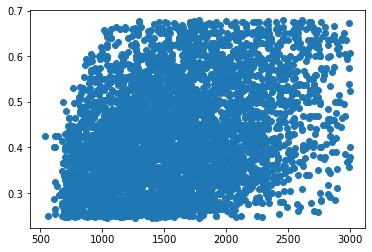

In [58]:
#1. The relationship between the target and predictor is linear. sqft_living vs price seems generally linear
plt.scatter(df_alt_no_outliers_seattle['sqft_living'], df_alt_no_outliers_seattle['price_adjusted_M'])

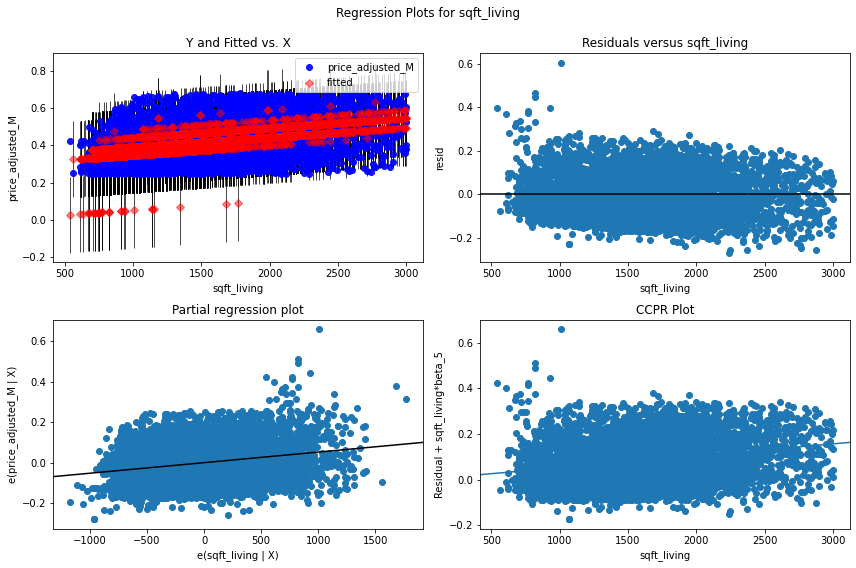

In [45]:
#2. The errors are independent - no apparent patterns in the residuals versus sqft_living plot?

sm.graphics.plot_regress_exog(model, 'sqft_living', fig=plt.figure(figsize=(12, 8)));

<ipython-input-46-f2695b92ec27>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


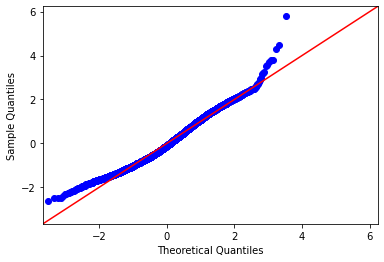

In [46]:
#3. The errors are normally distributed - mostly True

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [47]:
#4. The errors are homoskedastic (errors have the same variance) - True? 

sms.het_goldfeldquandt(model.resid, model.model.exog)

#The larger the F-statistic, the more evidence we will have against the homoscedasticity assumption 
#and the more likely we have heteroscedasticity (different variance for the two groups).



(1.027866892428551, 0.25396042502076915, 'increasing')

In [48]:
df_long_lat = df_alt_no_outliers_seattle[['lat', 'long']]
boundaries = (df_long_lat.long.min(), df_long_lat.long.max(), df_long_lat.lat.min(), df_long_lat.lat.max())
boundaries

(-122.414, -122.22200000000001, 47.3444, 47.7776)